In [82]:
%matplotlib inline

# imports
import pandas as pd
import numpy as np

from PIL import Image
from torchvision.io import read_image, ImageReadMode
import os

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [83]:
# const

#DIR_PATH = "../dataset/brain-tumor-mri"
DIR_PATH = "/kaggle/input/brain-tumor-mri-dataset"

LABELS = ["notumor", "glioma", "meningioma", "pituitary"]

TRAIN_PERCENT = .7
VAL_PERCENT = .2
TEST_PERCENT = .1

IMAGE_SIZE = 128

RANDOM_STATE = None

BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCH = 200
EARLY_PATIENCE = 10
SCHEDULER_PATIENCE = 6

# Data Manipulation

In [84]:
# creamos un dataset de la forma (path, class)
dataset = pd.DataFrame(columns = ["path", "label"])


for dir in os.listdir(DIR_PATH):
    for label in os.listdir(os.path.join(DIR_PATH, dir)):
        for img in os.listdir(os.path.join(DIR_PATH, dir, label)):
            dataset.loc[len(dataset)] = {"path": os.path.join(DIR_PATH, dir, label, img),
                                   "label": LABELS.index(label) }


print("num elementos:", dataset.count(axis=1).size)
print(dataset.head())

num elementos: 7023
                                                path  label
0  /kaggle/input/brain-tumor-mri-dataset/Training...      3
1  /kaggle/input/brain-tumor-mri-dataset/Training...      3
2  /kaggle/input/brain-tumor-mri-dataset/Training...      3
3  /kaggle/input/brain-tumor-mri-dataset/Training...      3
4  /kaggle/input/brain-tumor-mri-dataset/Training...      3


In [85]:
min_cat_size = dataset.label.value_counts().min()

print("> Cantidad de imagenes de la categoria que menos tiene:", min_cat_size)

> Cantidad de imagenes de la categoria que menos tiene: 1621


In [86]:
# Hacemos que todos tengan los mismos elementos
dataset = pd.DataFrame(dataset.groupby("label").apply(lambda label: label.sample(min_cat_size, random_state=RANDOM_STATE)).reset_index(drop=True))

print("> Cantidad de elementos: ", dataset.count(axis=1).size)
print(dataset.label.value_counts())
print(dataset.head())

> Cantidad de elementos:  6484
label
0    1621
1    1621
2    1621
3    1621
Name: count, dtype: int64
                                                path  label
0  /kaggle/input/brain-tumor-mri-dataset/Training...      0
1  /kaggle/input/brain-tumor-mri-dataset/Testing/...      0
2  /kaggle/input/brain-tumor-mri-dataset/Training...      0
3  /kaggle/input/brain-tumor-mri-dataset/Training...      0
4  /kaggle/input/brain-tumor-mri-dataset/Training...      0


In [87]:
# separamos en los cjtos de entrenamiento
train_dataset, tmp = train_test_split(dataset, train_size=TRAIN_PERCENT, stratify=dataset["label"], shuffle=True, random_state=RANDOM_STATE)
val_dataset, test_dataset = train_test_split(tmp, test_size=TEST_PERCENT/(TEST_PERCENT+VAL_PERCENT), stratify=tmp["label"], shuffle=True, random_state=RANDOM_STATE)

print("> train", train_dataset.count(axis=1).size, train_dataset.count(axis=1).size/dataset.count(axis=1).size)
print(train_dataset.label.value_counts())
print()

print("> val", val_dataset.count(axis=1).size, val_dataset.count(axis=1).size/dataset.count(axis=1).size)
print(val_dataset.label.value_counts())
print()

print("> test", test_dataset.count(axis=1).size, test_dataset.count(axis=1).size/dataset.count(axis=1).size)
print(test_dataset.label.value_counts())
print()

> train 4538 0.6998766193707588
label
2    1135
3    1135
0    1134
1    1134
Name: count, dtype: int64

> val 1297 0.2000308451573103
label
0    325
2    324
1    324
3    324
Name: count, dtype: int64

> test 649 0.10009253547193091
label
1    163
3    162
0    162
2    162
Name: count, dtype: int64



In [88]:
# Comprobamos que son disjuntos
print((train_dataset[ "path" ].isin(test_dataset["path"] ) == True).value_counts())
print((train_dataset[ "path" ].isin(val_dataset["path"] ) == True).value_counts())
print((val_dataset[ "path" ].isin(test_dataset["path"]) == True).value_counts())

path
False    4538
Name: count, dtype: int64
path
False    4538
Name: count, dtype: int64
path
False    1297
Name: count, dtype: int64


# Preparations

## Classes

In [89]:
class CustomDataset(Dataset):
    
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return self.dataframe.count(axis=1).size
    
    def __getitem__(self, idx) -> (str, int):
        
        row = self.dataframe.iloc[idx]
        img, label = row.path, row.label

        img = read_image(img, mode=ImageReadMode.GRAY)
        if self.transform: img = self.transform(img)

        return img, label

In [90]:
class EarlyStopper:
    
    def __init__(self, patience=5, min_delta=0, callback=lambda **_: None):
        self.patience = patience
        self.min_delta = min_delta
        self.callback = callback

        self.counter = 1

        self.best_model = None
        self.best_loss = float("inf")

    def __call__(self, val_loss, model):

        if val_loss < (self.best_loss - self.min_delta):
            self.best_loss = val_loss
            self.counter = 0

            self.best_model = model.state_dict()
            return False


        self.counter += 1
        if self.counter >= self.patience:
            self.callback(counter=self.counter, best_loss=self.best_loss, best_model=self.best_model)
            return True

    def reset(self):
        self.early_stop = False
        self.counter = 1

In [91]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        
        # Capas convolucionales
        self.convin = nn.Conv2d( 1, 64, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.Conv2d( 64, 64, kernel_size=3, stride=1, padding=1)
        self.convout = nn.Conv2d( 64, 128, kernel_size=3, stride=1, padding=1)

        # Capas Fully connected 
        # ajustado para 128
        self.fcin = nn.Linear(in_features=IMAGE_SIZE * 16 * 16, out_features=128)
        self.fcout = nn.Linear(in_features=128, out_features=len(LABELS))

        # BatchNorm2d
        self.bn1 = nn.BatchNorm2d(64)
        self.bnout = nn.BatchNorm2d(128)
        
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Capa Dropout 
        self.dropout25 = nn.Dropout(0.25)
        
            

    def forward(self, x):

        # conv in
        x = self.pool(F.relu(self.convin(x)))

        # conv 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout25(x)

        # conv out
        x = self.pool(F.relu(self.bnout(self.convout(x)))) 
        x = self.dropout25(x)
    
        # flatten
        x = x.view(-1, 128*16*16)

        # fully in
        x = F.relu(self.fcin(x))
        x = self.dropout25(x)

        # fully out
        x = self.fcout(x)
        
        return x

## Functions

In [92]:
def eval(model, loader, *, device = None, criterion = None):
    """returns pred, real, accuracy, val_loss"""
    if not (device and criterion): raise Exception("Params needed")

    model.eval()

    corrects = 0

    pred = []
    real = []
    loss = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            
            imgs, labels = imgs.to(device), labels.to(device)

            outs = model(imgs)
            loss += criterion(outs.data, labels).item()

            _, predicted = torch.max(outs.data, 1)
            
            total += labels.size(0)
            pred.extend(predicted.tolist())
            real.extend(labels.tolist())

            corrects += (predicted == labels).sum().item()
    
    return  pred, real, loss/len(loader), corrects/total

In [93]:
def train_loop(model, loader, *, optimizer, criterion, num_epoch=100, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), train_loss_h=[], train_acc_h=[], val_loss_h=[] ,val_acc_h=[], callback=lambda **_: None, early_callback=lambda **_: None, scheduler, val_loader):
    if not (optimizer and criterion and early_stopper and scheduler): raise Exception("Params needed")
    
    val_preds, val_labels, val_loss, val_acc  = eval(model, val_loader, device=device, criterion=criterion)
    callback(epoch=0, val_acc=val_acc, val_loss=val_loss, train_loss=float("inf"), train_acc=0)

    for epoch in range(num_epoch):

        running_loss = 0.0
        corrects = 0
        total = 0

        model.train()

        for i, (imgs, labels) in enumerate(loader, 1):

            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outs = model(imgs)
            loss = criterion(outs, labels)
            
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()

            # extra for analytics
            _, predicted = torch.max(outs, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()
            # ==================

            if not i % 10:
                print(f"\tEpoch {epoch+1}, Batch {i}: Loss: {running_loss*(len(loader)-i+1)/(10*len(loader)):.4f}")
            
        val_preds, val_labels, val_loss, val_acc  = eval(model, val_loader, device=device, criterion=criterion)
        scheduler.step(val_loss)
        
        # extra for analytics
        train_loss = running_loss/len(loader)
        train_loss_h.append(train_loss)
        train_acc = 100*corrects/total
        train_acc_h.append(train_acc)

        val_loss_h.append(val_loss)
        val_acc_h.append(val_acc*100)
        # ===================

        callback(epoch=epoch+1, val_acc=val_acc, val_loss=val_loss, train_loss=train_loss, train_acc=train_acc)

        if(early_stopper(val_loss, model)): break

    return train_acc_h, val_acc_h, train_loss_h, val_loss_h, val_preds, val_labels

# Utils

In [94]:
def save_model(model, path, complete=False):
    try:
        torch.save(model if complete else model.state_dict(), path)
    except Exception as e:
        print("Error al guardar el model:", e)

In [95]:
def show_img(img, label):
    print('Label: ', dataset.label[label], "(" + str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

## Dataset statistics

In [96]:
unnormalized_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    transforms.ToTensor()
])

unnormalized_dataset = CustomDataset(dataset, transform=unnormalized_transforms)
loader = DataLoader(unnormalized_dataset, batch_size=1, shuffle=False)

sum_intensity = 0.0
sum_squared_intensity = 0.0
n_samples = 0

for imgs, _ in loader:
    
    sum_intensity += imgs.sum()
    sum_squared_intensity += (imgs ** 2).sum()
    n_samples += imgs.numel()

mean = sum_intensity / n_samples
std = torch.sqrt(sum_squared_intensity / n_samples - mean ** 2)

print(mean)
print(std)

tensor(0.1842)
tensor(0.1950)


In [97]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    transforms.RandomRotation(180),            
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

test_valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE),antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])


train_dataset = CustomDataset(train_dataset, transform=train_transform)
val_dataset = CustomDataset(val_dataset, transform=test_valid_transforms)
test_dataset = CustomDataset(test_dataset, transform=test_valid_transforms)

# Acceder e imprimir las primeras 5 muestras del dataset
for i in range(5):
    image, label = train_dataset[i]
    print(f"Muestra {i}: Imagen - {type(image)}, Dimensiones - {image.size()}, Etiqueta - {label}")
    image, label = val_dataset[i]
    print(f"Muestra {i}: Imagen - {type(image)}, Dimensiones - {image.size()}, Etiqueta - {label}")
    image, label = test_dataset[i]
    print(f"Muestra {i}: Imagen - {type(image)}, Dimensiones - {image.size()}, Etiqueta - {label}")

# Imprimir los valores de la media y la desviación estándar
print(f"Media: {mean}, Desviación Estándar: {std}")

Muestra 0: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 128, 128]), Etiqueta - 0
Muestra 0: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 128, 128]), Etiqueta - 2
Muestra 0: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 128, 128]), Etiqueta - 3
Muestra 1: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 128, 128]), Etiqueta - 2
Muestra 1: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 128, 128]), Etiqueta - 1
Muestra 1: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 128, 128]), Etiqueta - 3
Muestra 2: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 128, 128]), Etiqueta - 3
Muestra 2: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 128, 128]), Etiqueta - 0
Muestra 2: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 128, 128]), Etiqueta - 3
Muestra 3: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 128, 128]), Etiqueta - 2
Muestra 3: Imagen - 

Batch de imágenes: torch.Size([64, 1, 128, 128]), Batch de etiquetas: torch.Size([64])
Label:  0 (1)


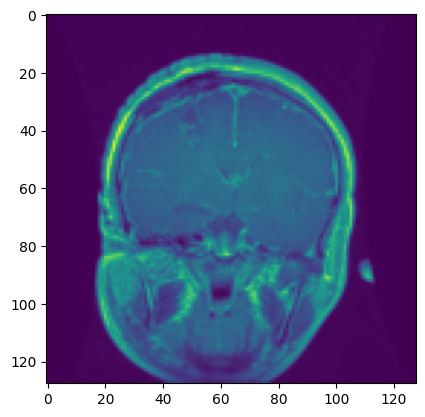

In [98]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Verificar DataLoader
for images, labels in train_loader:
    print(f"Batch de imágenes: {images.shape}, Batch de etiquetas: {labels.shape}")
    break

# Carga una imagen de prueba
img, label = test_dataset[45]
show_img(img, label)

## Comprobaciones previas de la GPU

In [99]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo configurado para usar: {device}")

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.0.0
Dispositivo configurado para usar: cuda
True
Tesla P100-PCIE-16GB


## Entrenamos

In [100]:
def early_callback(**kwargs): print("> Early stopping <")

early_stopper = EarlyStopper(patience=EARLY_PATIENCE, min_delta=.001, callback=early_callback)

In [102]:
model = CNN()
if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=SCHEDULER_PATIENCE, verbose=True)

def callback(**kwargs):
    print(f"Epoch: {kwargs['epoch']}, val_loss: {(kwargs['val_loss']):.2f}, train_loss: {(kwargs['train_loss']):.2f} val_acc: {(kwargs['val_acc']*100):.2f}, train_acc: {(kwargs['train_acc']):.2f}")

train_acc_h, val_acc_h, train_loss_h, val_loss_h, preds, targets = train_loop(model, train_loader,
           val_loader=val_loader,                                                                                  
           optimizer=optimizer,
           criterion=criterion,
           num_epoch=NUM_EPOCH,
           device=device,
           callback=callback,
           scheduler=scheduler
           )

Epoch: 0, val_loss: 1.39, train_loss: inf val_acc: 24.60, train_acc: 0.00
	Epoch 1, Batch 10: Loss: 5.4092
	Epoch 1, Batch 20: Loss: 5.5866
	Epoch 1, Batch 30: Loss: 5.2445
	Epoch 1, Batch 40: Loss: 4.5164
	Epoch 1, Batch 50: Loss: 3.4714
	Epoch 1, Batch 60: Loss: 2.0841
	Epoch 1, Batch 70: Loss: 0.3790
Epoch: 1, val_loss: 1.05, train_loss: 1.91 val_acc: 38.24, train_acc: 35.41
	Epoch 2, Batch 10: Loss: 1.0003
	Epoch 2, Batch 20: Loss: 1.6664
	Epoch 2, Batch 30: Loss: 1.9976
	Epoch 2, Batch 40: Loss: 1.9949
	Epoch 2, Batch 50: Loss: 1.7118
	Epoch 2, Batch 60: Loss: 1.1161
	Epoch 2, Batch 70: Loss: 0.2157
Epoch: 2, val_loss: 1.01, train_loss: 1.09 val_acc: 58.75, train_acc: 42.51
	Epoch 3, Batch 10: Loss: 0.9053
	Epoch 3, Batch 20: Loss: 1.4893
	Epoch 3, Batch 30: Loss: 1.8079
	Epoch 3, Batch 40: Loss: 1.8409
	Epoch 3, Batch 50: Loss: 1.5893
	Epoch 3, Batch 60: Loss: 1.0412
	Epoch 3, Batch 70: Loss: 0.2013
Epoch: 3, val_loss: 0.99, train_loss: 1.02 val_acc: 61.30, train_acc: 59.78
	Epoc

# Analizamos los datos

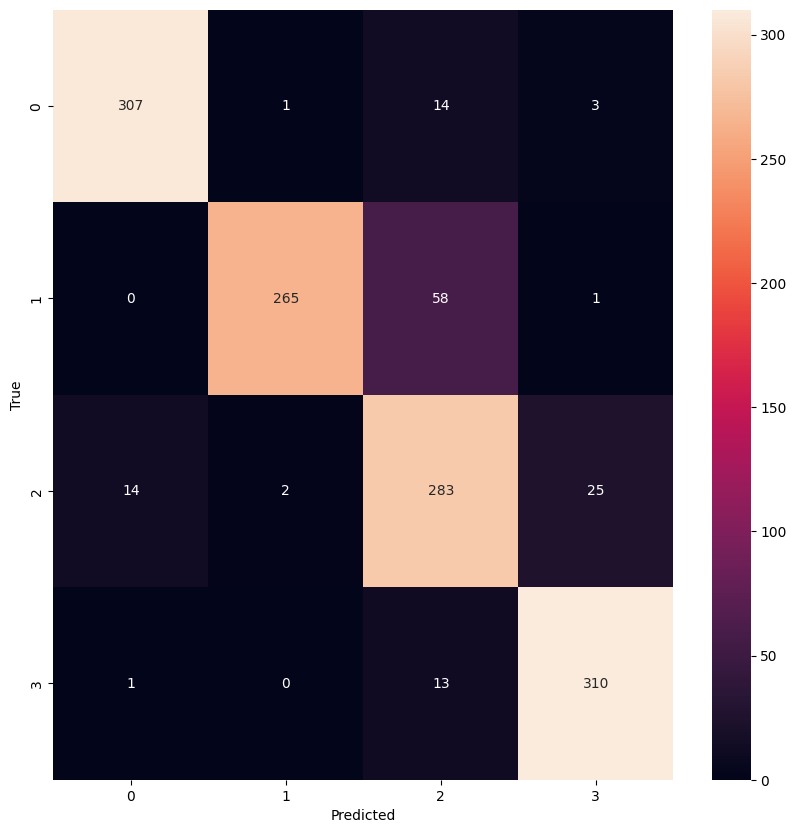

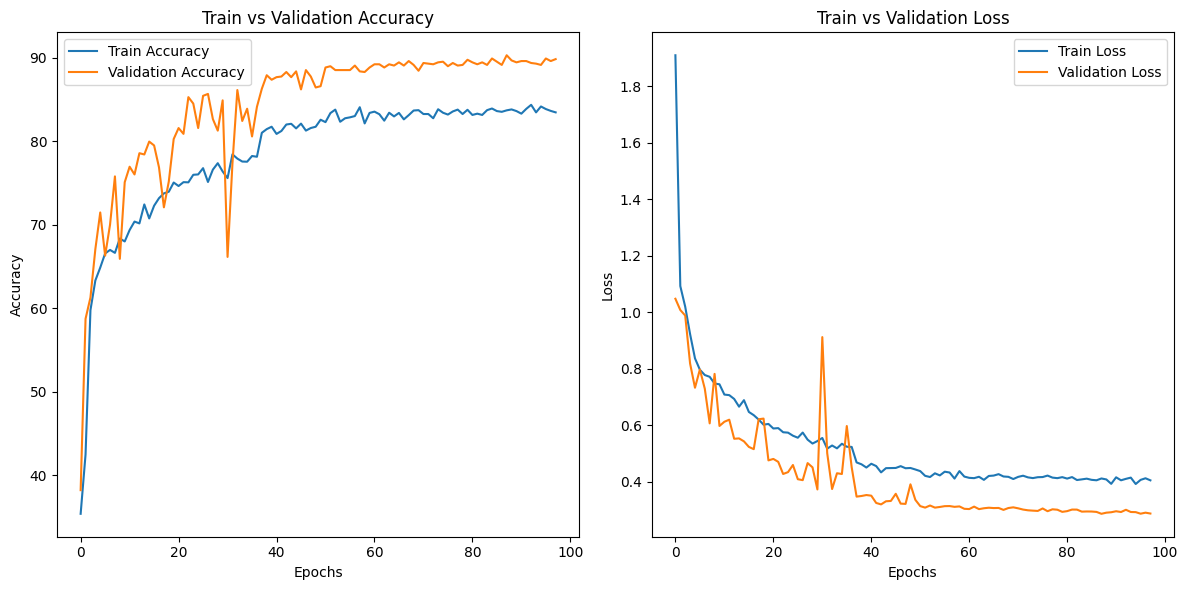

Train Dataset ----------------------------------------------------------------
test_loss: 0.2684711276645392 - test_acc: 0.9017188188629353
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1134
           1       0.95      0.84      0.89      1134
           2       0.81      0.82      0.81      1135
           3       0.92      0.98      0.95      1135

    accuracy                           0.90      4538
   macro avg       0.90      0.90      0.90      4538
weighted avg       0.90      0.90      0.90      4538

Val Dataset ----------------------------------------------------------------
test_loss: 0.28803002550488427 - test_acc: 0.8982266769468004
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       325
           1       0.99      0.82      0.90       324
           2       0.77      0.87      0.82       324
           3       0.91      0.96      0.94       324

    accuracy  

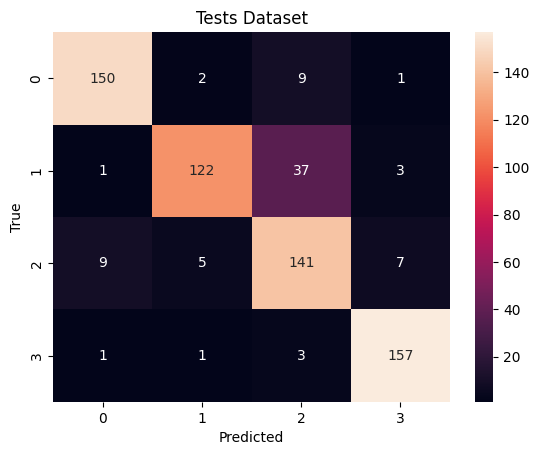

Tests Dataset ----------------------------------------------------------------
test_loss: 0.33557841114022513 - test_acc: 0.8782742681047766
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       162
           1       0.94      0.75      0.83       163
           2       0.74      0.87      0.80       162
           3       0.93      0.97      0.95       162

    accuracy                           0.88       649
   macro avg       0.89      0.88      0.88       649
weighted avg       0.89      0.88      0.88       649



In [105]:
model.load_state_dict(early_stopper.best_model)
model.eval()

cm = metrics.confusion_matrix(targets, preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Gráfico de la precisión de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc_h, label='Train Accuracy')
plt.plot(val_acc_h, label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Gráfico de la pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(train_loss_h, label='Train Loss')
plt.plot(val_loss_h, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# cjto train
train_preds, train_reals, train_loss, train_acc = eval(model, train_loader, device=device, criterion=criterion)
print("Train Dataset ----------------------------------------------------------------")
print(f"train_loss: {train_loss} - train_acc: {train_acc}")
print(metrics.classification_report(train_reals, train_preds, zero_division=0))


# cjto val
val_preds, val_reals, val_loss, val_acc = eval(model, val_loader, device=device, criterion=criterion)
print("Val Dataset ----------------------------------------------------------------")
print(f"val_loss: {val_loss} - val_acc: {val_acc}")
print(metrics.classification_report(val_reals, val_preds, zero_division=0))

# cjto tests
test_preds, test_reals, test_loss, test_acc = eval(model, test_loader, device=device, criterion=criterion)
cm = metrics.confusion_matrix(test_reals, test_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Tests Dataset")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Tests Dataset ----------------------------------------------------------------")
print(f"test_loss: {test_loss} - test_acc: {test_acc}")
print(metrics.classification_report(test_reals, test_preds, zero_division=0))

In [ ]:
save_model(model, "/kaggle/working/model.pth", complete=True)